# E commerce Text Classification using Transfer Learning

[Dataset](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification)<br>

This is the classification based E-commerce text dataset for 4 classes - "Electronics", "Household", "Books" and "Clothing & Accessories", which almost cover 80% of any E-commerce website.

Pretrained model used: **DistilBERT**

## Import libraries

In [28]:
!pip install WordCloud

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
from datasets.features import Value, ClassLabel
from datasets import Features
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorWithPadding

## Import Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = "/content/drive/MyDrive/NLP/FA2/data/ecommerceDataset.csv"
df = pd.read_csv(data_path, header=None)
df.columns = ['category', 'text']

In [6]:
df.head()

,category,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


## Visualization

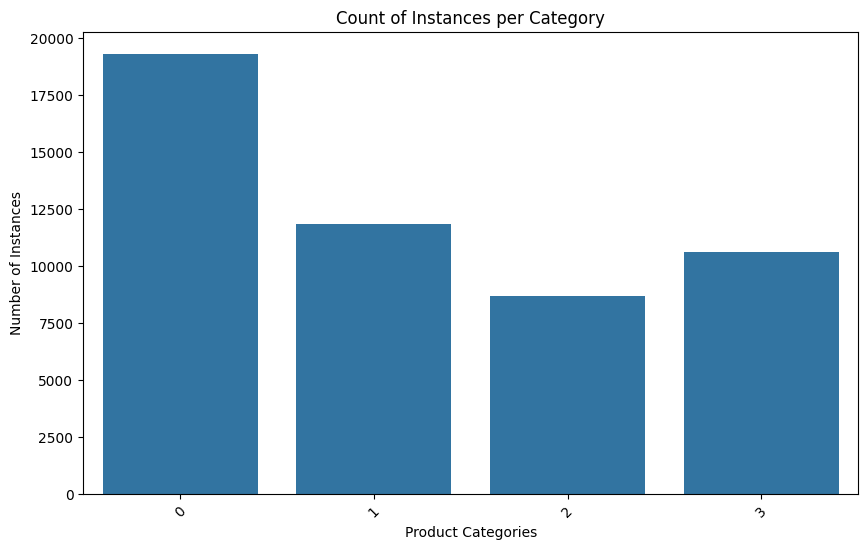

In [25]:
category_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel('Product Categories')
plt.ylabel('Number of Instances')
plt.title('Count of Instances per Category')
plt.xticks(rotation=45)
plt.show()

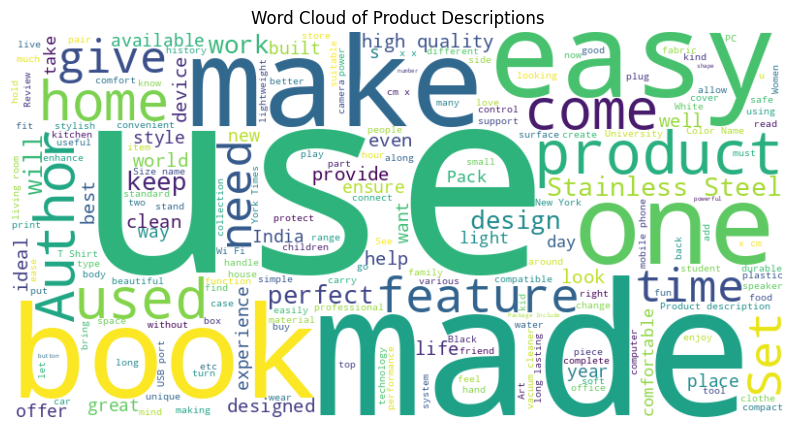

In [30]:
valid_descriptions = [desc for desc in df['text'] if isinstance(desc, str)]

text = ' '.join(valid_descriptions)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Product Descriptions')
plt.show()

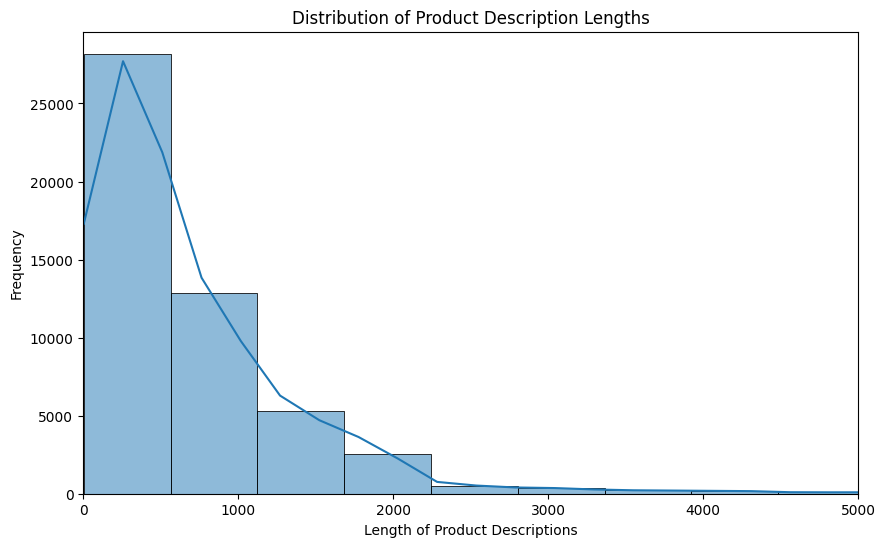

In [31]:
df['description_length'] = df['text'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df['description_length'], bins=90, kde=True)
plt.xlabel('Length of Product Descriptions')
plt.ylabel('Frequency')
plt.title('Distribution of Product Description Lengths')
plt.xlim(0, 5000)
plt.show()

## Label To Index and Index to Label Maps.

In [7]:
# label map
label2idx = {label:i for i, label in enumerate(df.category.unique().tolist())}
label2idx

{'Household': 0, 'Books': 1, 'Clothing & Accessories': 2, 'Electronics': 3}

In [8]:
# reverse for correct structure
idx2label = {v:k for k,v in label2idx.items()}
idx2label

{0: 'Household', 1: 'Books', 2: 'Clothing & Accessories', 3: 'Electronics'}

## Encoding

In [9]:
df['label'] = df.category.map(label2idx)

In [10]:
df

,category,text,label
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,0
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",0
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,0
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",0
4,Household,Incredible Gifts India Wooden Happy Birthday U...,0
...,...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,3
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,3
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,3
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",3


## Cleaning

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  50425 non-null  object
 1   text      50424 non-null  object
 2   label     50425 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


#### We've got one **Null** value in the **text** column.

In [12]:
df.isna().sum()

,0
category,0
text,1
label,0


In [13]:
df[df.text.isna()]

,category,text,label
39330,Clothing & Accessories,NaN,2


since only 1, we can drop it

In [14]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['category'], inplace=True)

## Train Test Validation Split

In [15]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=df['label'], random_state=42)
train_df, eval_df = train_test_split(train_df, test_size=0.2, shuffle=True, stratify=train_df['label'], random_state=42)

In [16]:
train_df.shape, test_df.shape, eval_df.shape

((32271, 2), (10085, 2), (8068, 2))

### Verify stratification

In [17]:
train_df.label.value_counts(normalize=True)

,proportion
label,
0,0.383006
1,0.234421
3,0.210623
2,0.171950


In [18]:
test_df.label.value_counts(normalize=True)

,proportion
label,
0,0.383044
1,0.234408
3,0.210610
2,0.171939


In [19]:
eval_df.label.value_counts(normalize=True)

,proportion
label,
0,0.382995
1,0.234383
3,0.210709
2,0.171914


## Convert dataframes to transformers datasets

In [20]:
features=Features({"text": Value(dtype='string', id=None),
                "label": ClassLabel(num_classes=4,
                                    names=['Household', 'Books', 'Clothing & Accessories', 'Electronics'], id=None)})

### Dataframes to datasets.

In [ ]:
train_dataset = Dataset.from_pandas(train_df, features=features)
test_dataset = Dataset.from_pandas(test_df, features=features)
eval_dataset = Dataset.from_pandas(eval_df, features=features)

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 32271
})

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=4, names=['Household', 'Books', 'Clothing & Accessories', 'Electronics'], id=None)}

In [ ]:
test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 10085
})

In [ ]:
eval_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 8068
})

## Create a Dataset Dict. (Optional)

Dataset Dict can hold data subsets. For example, our train, test and validation subsets.

In [ ]:
dataset = DatasetDict({"train": train_dataset, "test": test_dataset, "validation": eval_dataset}) # dict combining all the datasets

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32271
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10085
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8068
    })
})

## Tokenization

In [21]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True)

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

## Padding

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Load DistilBERT Model.

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=4)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [ ]:
training_args = TrainingArguments(per_device_train_batch_size=32,
                                 per_device_eval_batch_size=16,
                                 learning_rate=5e-5,
                                 num_train_epochs=5,
                                 evaluation_strategy='epoch',
                                 load_best_model_at_end=True
                                 )

In [ ]:
trainer = Trainer(model=model,
                 args=training_args,
                 train_dataset=tokenized_datasets['train'],
                 eval_dataset=tokenized_datasets['validation'],
                 data_collator=data_collator,
                 tokenizer=tokenizer)

In [ ]:
%%time
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.139200,0.139756
2,0.076800,0.109455
3,0.042400,0.103477
4,0.018700,0.097567
5,0.012300,0.104120


CPU times: user 1h 11min 54s, sys: 7.99 s, total: 1h 12min 2s
Wall time: 1h 11min 59s


TrainOutput(global_step=5045, training_loss=0.06804902793690046, metrics={'train_runtime': 4319.3742, 'train_samples_per_second': 37.356, 'train_steps_per_second': 1.168, 'total_flos': 2.007639532173895e+16, 'train_loss': 0.06804902793690046, 'epoch': 5.0})

## Inference

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])
predictions.predictions.shape

(10085, 4)

In [ ]:
preds = np.argmax(predictions.predictions, axis=-1)
test_df['preds'] = preds

In [ ]:
print(classification_report(test_df.label, test_df.preds, target_names=list(idx2label.values())))

                        precision    recall  f1-score   support

             Household       0.98      0.98      0.98      3863
                 Books       0.98      0.98      0.98      2364
Clothing & Accessories       0.99      0.99      0.99      1734
           Electronics       0.98      0.97      0.97      2124

              accuracy                           0.98     10085
             macro avg       0.98      0.98      0.98     10085
          weighted avg       0.98      0.98      0.98     10085



## Save model

In [ ]:
trainer.save_model("best_model/")